In [1]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Reiter cellular model for snow crystal growth

The value at cell $i$ and time $n$ is given by

$$
u^n_i = d^n_i + g^n_i 
$$

The diffusion term and growth term is given by

$$
g^n_i = ( u^{n-1}_i + \gamma ) \delta^{n-1}_i, \qquad d^n_i = \frac{1}{2} u^{n-1}_i (1-\delta^{n-1}_i) + \frac{1}{12} \sum_{j\in nn(i)} u^{n-1}_j (1-\delta^{n-1}_j)
$$

where $nn(i)$ denote the set of nearest neighbours of cell $i$ and

$$
\delta^n_i =
\begin{cases}
1 & \text{if $u^n_i \geq 1$ or $u^n_j \geq 1$ for some $j\in nn(i)$} \\
0 & \text{otherwise}
\end{cases}
$$

is the "receptive" state.

[1] Reiter, Clifford A. "A local cellular model for snow crystal growth." Chaos, Solitons & Fractals 23.4 (2005): 1111-1119

In [2]:
class Cell:
    
    def __init__(self, x, y, i, j, u):
        self.x = x
        self.y = y
        self.i = i
        self.j = j
        self.u = u
        self.isIce = False
        self.isReceptive = False
        
    def isI(self):
        return self.u >= 1.0
    
    def isR(self):
        if self.isIce:
            return True
        for n in self.neighbours:
            if n.isIce:
                return True
        return False
        
    def diffuse(self):
        d = 0.0
        for n in self.neighbours:
            d = d + n.u * (1-n.isReceptive)
        d = d / 12.0 + 0.5 * self.u * (1-self.isReceptive)
        return d
    
    def grow(self, gamma):
        return ( self.u + gamma ) * self.isReceptive


In [3]:
def getU(cells):
    N = len(cells)
    U = np.zeros(N)
    for i in range(N):
        U[i] = cells[i].u
    return U

def getID(i, j):
    a = (i+1)/2
    return math.floor(a)*math.ceil(a) + j

def show(X, Y, cells, size=13):
    N = len(cells)
    U = getU(cells)
    plt.figure(figsize=(size, size))
    sns.scatterplot(x=X[0:N], y=Y[0:N], hue=U, s=40)
    plt.axis('equal')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)
    
# def showIce(X, Y, cells, size=13):
#     U = getU(cells)
#     isIce = (U >= 1.0)
#     plt.figure(figsize=(size, size))
#     sns.scatterplot(x=X[isIce], y=Y[isIce], hue=U[isIce], s=3)
#     plt.axis('equal')
#     plt.xlim(-0.1, 1.1)
#     plt.ylim(-0.1, 1.1)

def showAll(X, Y, cells, size=13):
    U = np.tile(getU(cells), 3)
    plt.figure(figsize=(size, size))
    sns.scatterplot(x=X, y=Y, hue=U, s=40)
    plt.axis('equal')
    plt.xlim(-0.1, 1.1)
    plt.ylim(-0.1, 1.1)

0.0058025152682374456


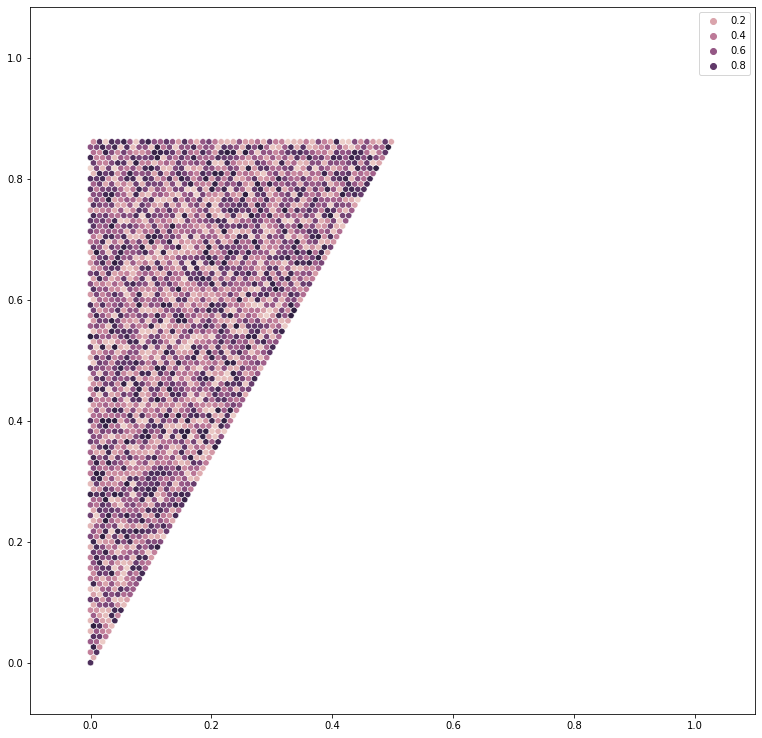

In [4]:
# generate mesh
L = 100

# grid position
x = np.arange(0, L, 1.0)
y = np.arange(0, L, 1.0)
X, Y = np.meshgrid(x, y)

# align hexagon
X[1::2,:] = X[1::2,:] + 0.5
X = X * math.sqrt(3)
Y = Y * 1.5

# rescale grid
xmax = X.max()
print(1/xmax)
X = X/xmax
Y = Y/xmax

# reshape
X = X.reshape(-1)
Y = Y.reshape(-1)

# create cells
cells = []
for i in range(L):
    for j in range(math.floor(i/2)+1):
        cells.append( Cell(X[i*L+j], Y[i*L+j], i, j, random.random()) )

# coords
N = len(cells)
X = np.zeros(N)
Y = np.zeros(N)
for i in range(N):
    X[i] = cells[i].x
    Y[i] = cells[i].y

show(X, Y, cells)

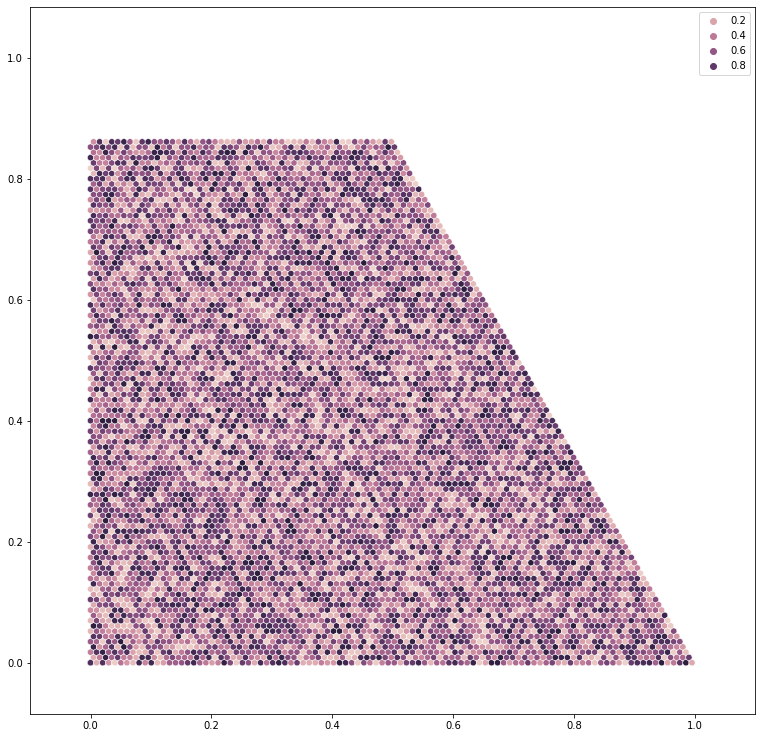

In [5]:
# mirror
XX = np.zeros(3*N)
YY = np.zeros(3*N)

for i in range(N):
    
    XX[i] = X[i]
    YY[i] = Y[i]
    
    # reflection matrix
    c1 = math.cos(2*math.pi/3)
    s1 = math.sin(2*math.pi/3)
    XX[i+N] = c1*X[i] + s1*Y[i]
    YY[i+N] = s1*X[i] - c1*Y[i]
    
    # rotation matrix
    c2 = math.cos(math.pi/3)
    s2 = math.sin(-math.pi/3)
    XX[i+2*N] = c2*X[i] - s2*Y[i]
    YY[i+2*N] = s2*X[i] + c2*Y[i]
    
X = XX
Y = YY

showAll(X, Y, cells)

In [6]:
# neighbours

cells[0].neighbours = [cells[1] for i in range(6)]
cells[1].neighbours = [cells[2], cells[3], cells[1], cells[2], cells[0], cells[1]]

for k in range(2, N-1):
    
    i = cells[k].i
    j = cells[k].j
    m = math.floor(i/2)+1
    
    if i % 2 == 0:
        
        if j == 0:
            n2 = cells[getID(i+1, j)]
            n4 = cells[getID(i, j+1)]
            n6 = cells[getID(i-1, j)]
            cells[k].neighbours = [n2, n2, n4, n4, n6, n6]
        elif j == m-1:
            n1 = cells[getID(i+1, j-1)]
            n2 = cells[getID(i+1, j)]
            n3 = cells[getID(i, j-1)]
            n5 = cells[getID(i-1, j-1)]
            cells[k].neighbours = [n1, n2, n3, n1, n5, n3]
        else:
            n1 = cells[getID(i+1, j-1)]
            n2 = cells[getID(i+1, j)]
            n3 = cells[getID(i, j-1)]
            n4 = cells[getID(i, j+1)]
            n5 = cells[getID(i-1, j-1)]
            n6 = cells[getID(i-1, j)]
            cells[k].neighbours = [n1, n2, n3, n4, n5, n6]
            
    else:
        if j == 0:
            if i == L-1:
                n4 = cells[getID(i, j+1)]
                n5 = cells[getID(i-1, j)]
                n6 = cells[getID(i-1, j+1)]
                cells[k].neighbours = [n5, n6, cells[k], n4, n5, n6]
            else:
                n1 = cells[getID(i+1, j)]
                n2 = cells[getID(i+1, j+1)]
                n4 = cells[getID(i, j+1)]
                n5 = cells[getID(i-1, j)]
                n6 = cells[getID(i-1, j+1)]
                cells[k].neighbours = [n1, n2, cells[k], n4, n5, n6]
        elif j == m-1:
            n1 = cells[getID(i+1, j)]
            n2 = cells[getID(i+1, j+1)]
            n3 = cells[getID(i, j-1)]
            n5 = cells[getID(i-1, j)]
            cells[k].neighbours = [n1, n2, n3, n1, n5, n3]
        else:
            if i == L-1:
                n3 = cells[getID(i, j-1)]
                n4 = cells[getID(i, j+1)]
                n5 = cells[getID(i-1, j)]
                n6 = cells[getID(i-1, j+1)]
                cells[k].neighbours = [n5, n6, n3, n4, n5, n6]
            else:
                n1 = cells[getID(i+1, j)]
                n2 = cells[getID(i+1, j+1)]
                n3 = cells[getID(i, j-1)]
                n4 = cells[getID(i, j+1)]
                n5 = cells[getID(i-1, j)]
                n6 = cells[getID(i-1, j+1)]
                cells[k].neighbours = [n1, n2, n3, n4, n5, n6]

# k = N-1 case
k = N-1
i = cells[k].i
j = cells[k].j
n3 = cells[k-1]
n5 = cells[getID(i-1, j)]
cells[k].neighbours = [n5, n5, n3, n5, n5, n3]


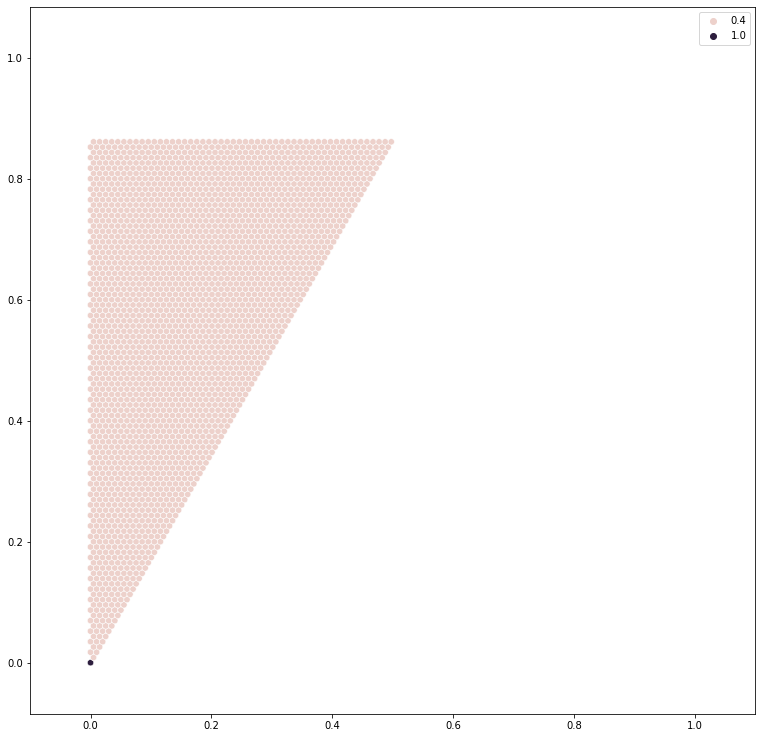

In [7]:
# numerical parameters
beta = 0.4         # background level
gamma = 0.0001      # growth rate

# initial condition
for i in range(N):
    cells[i].u = beta 
cells[0].u = 1.0

show(X, Y, cells)

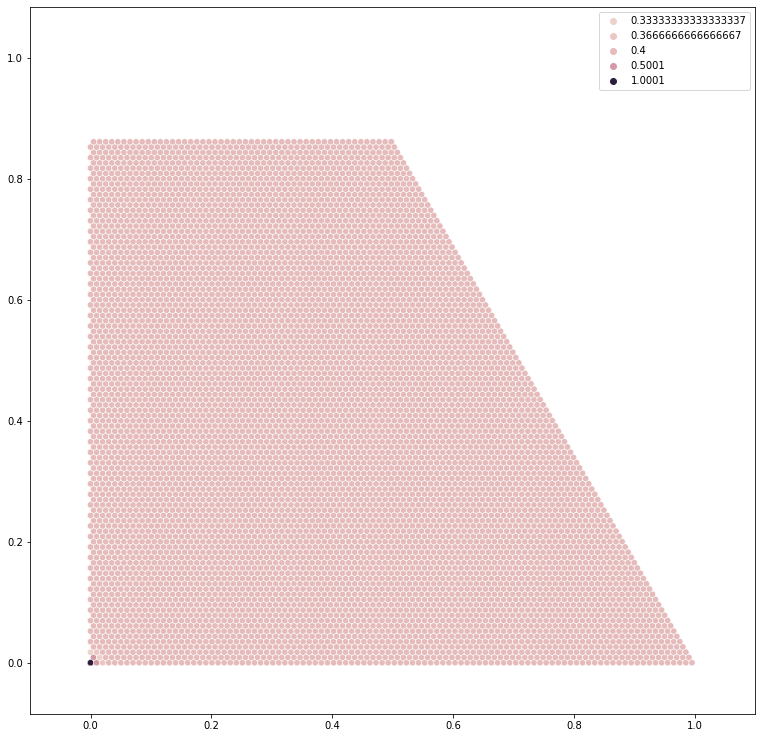

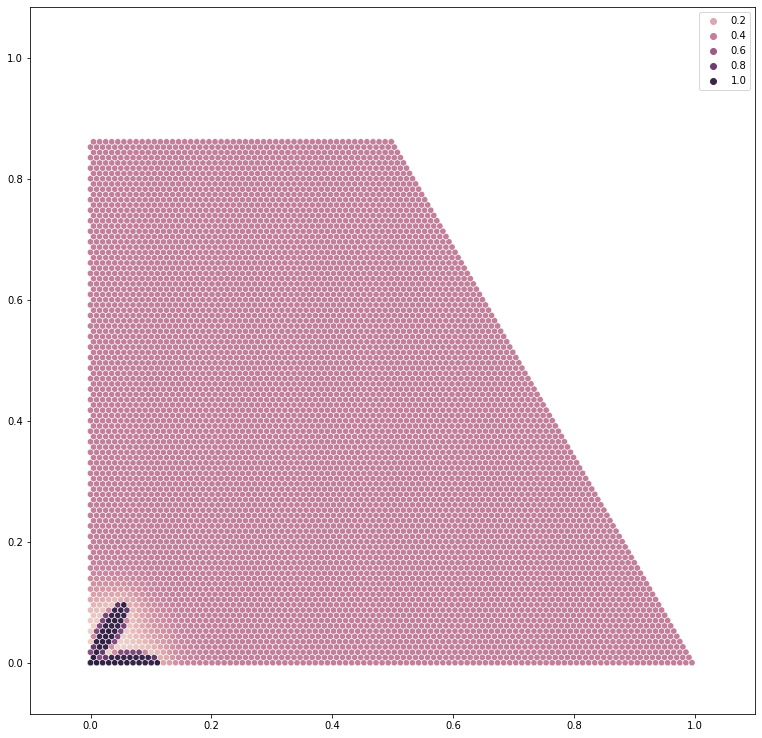

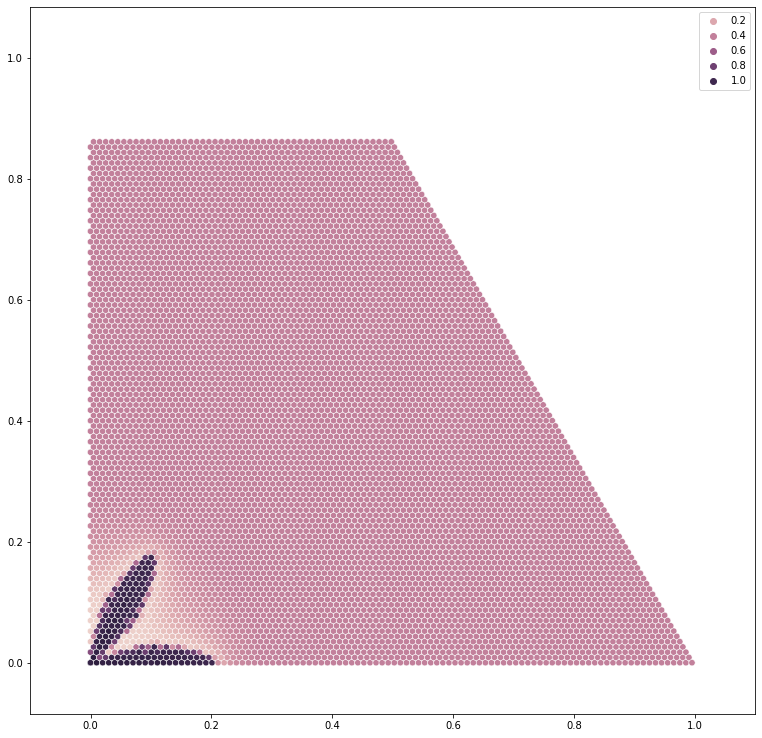

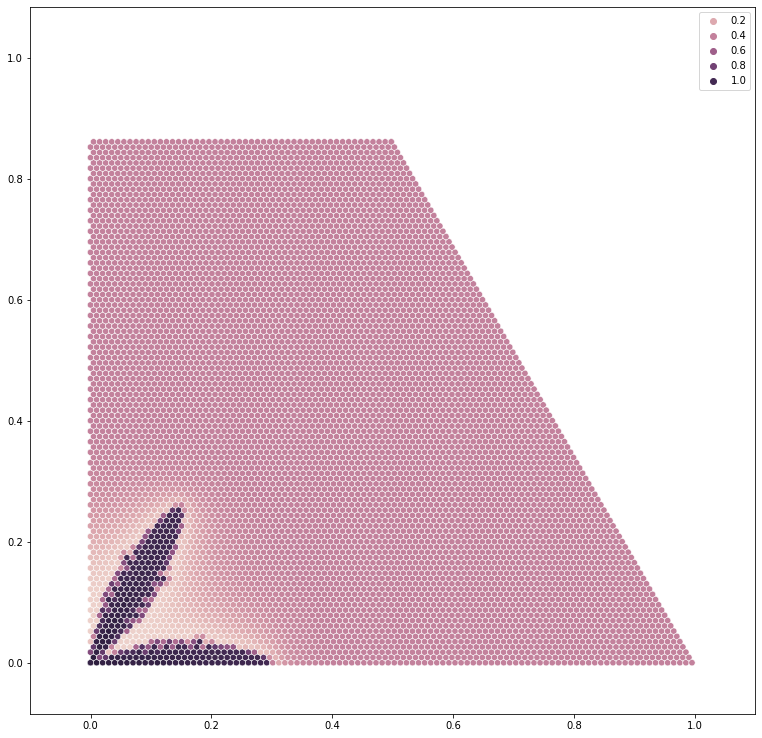

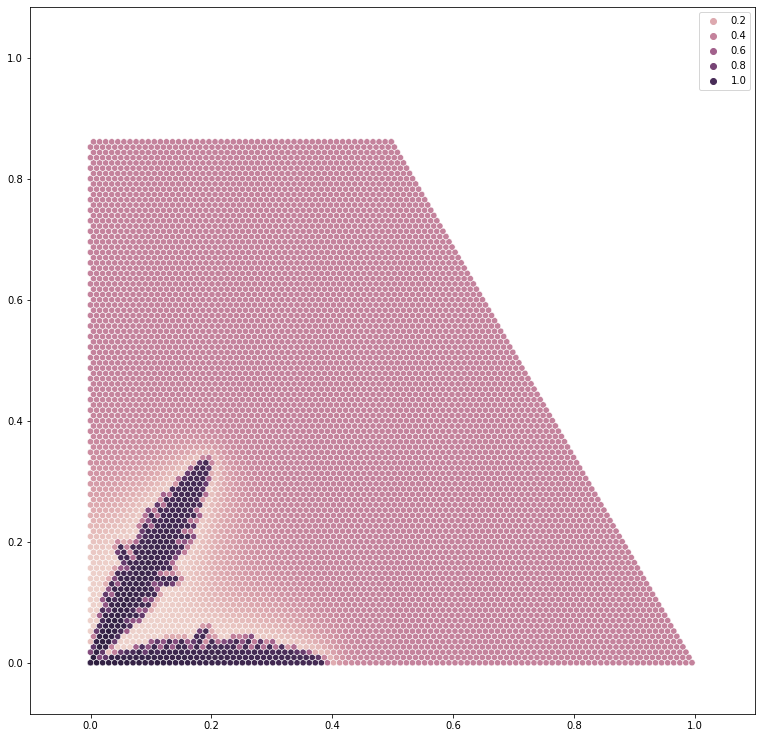

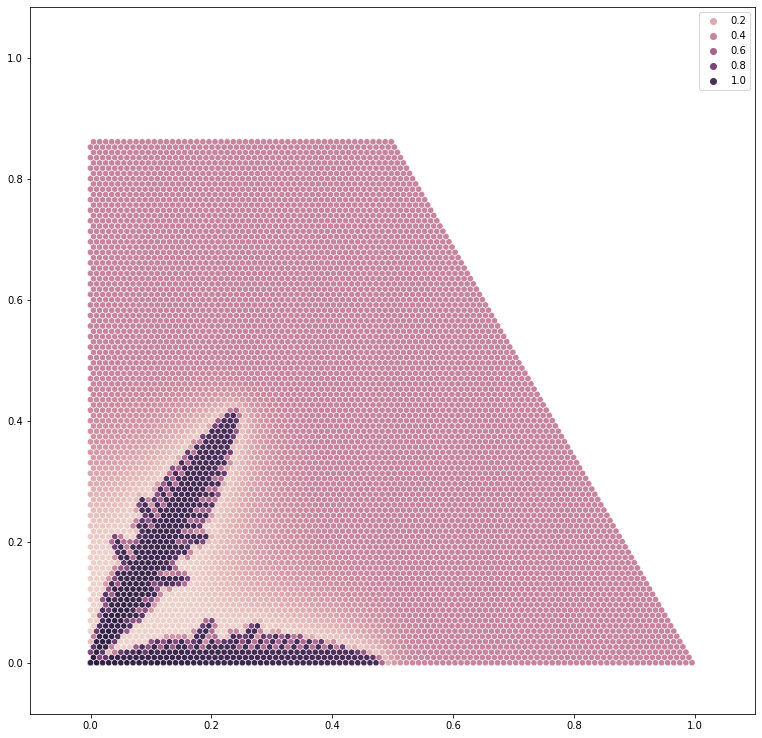

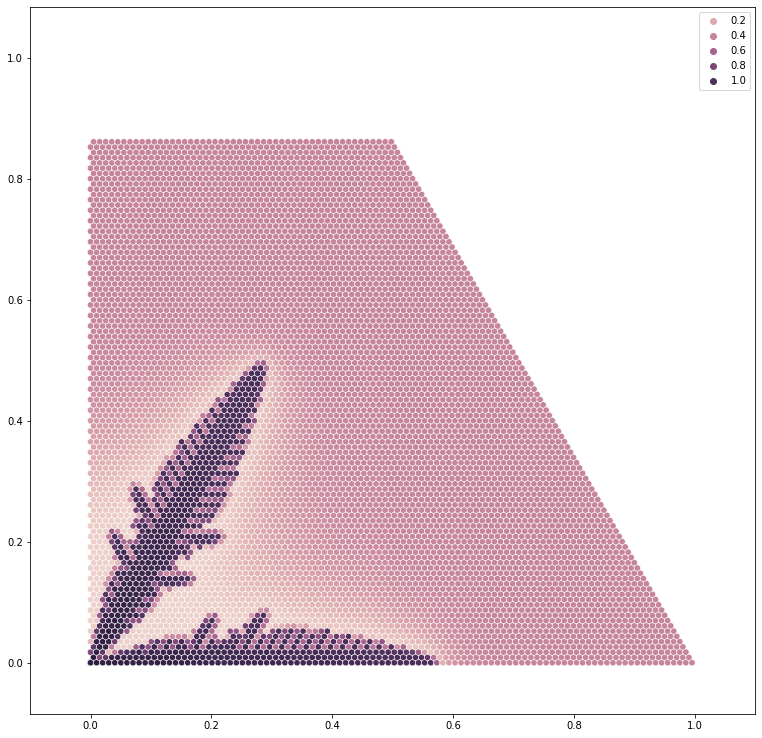

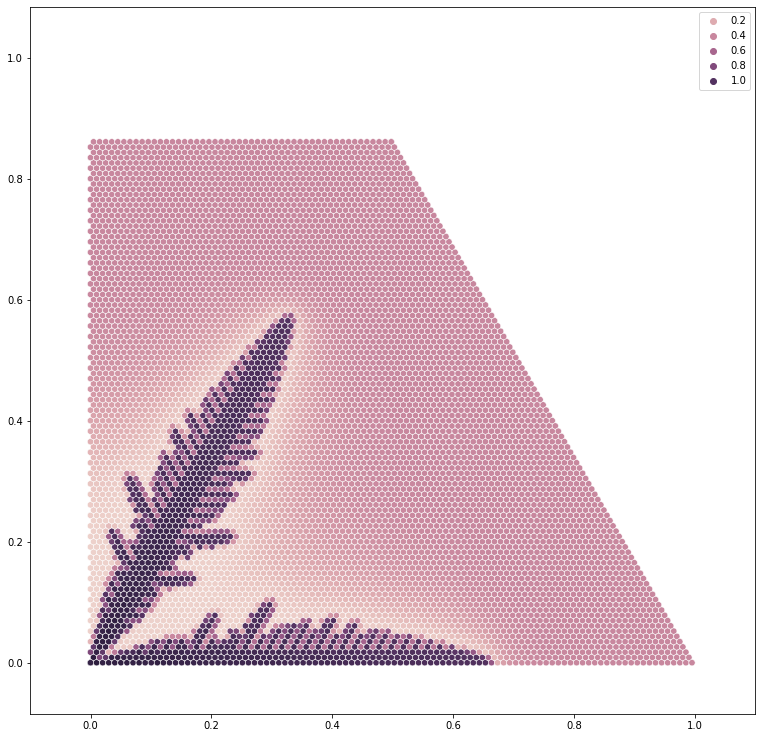

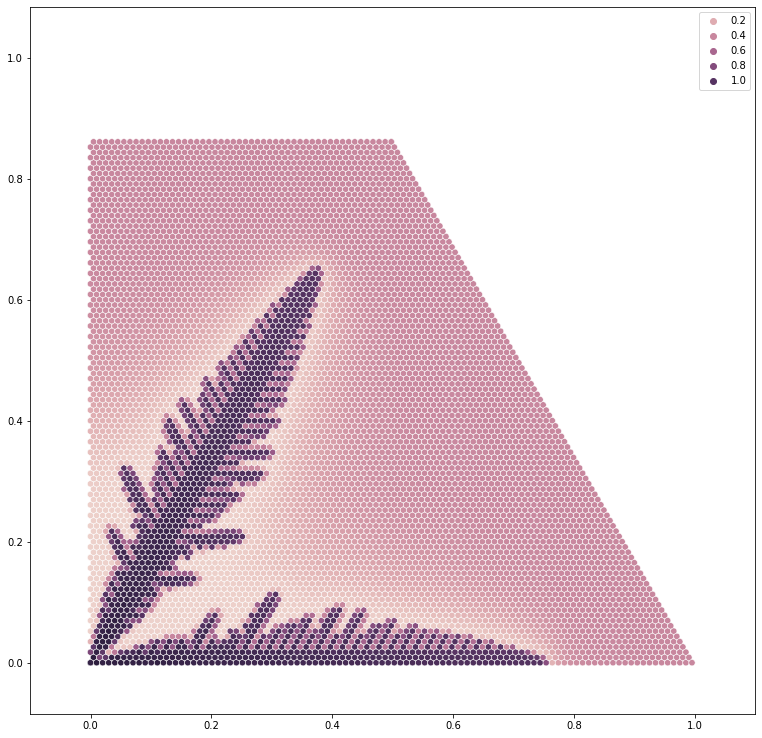

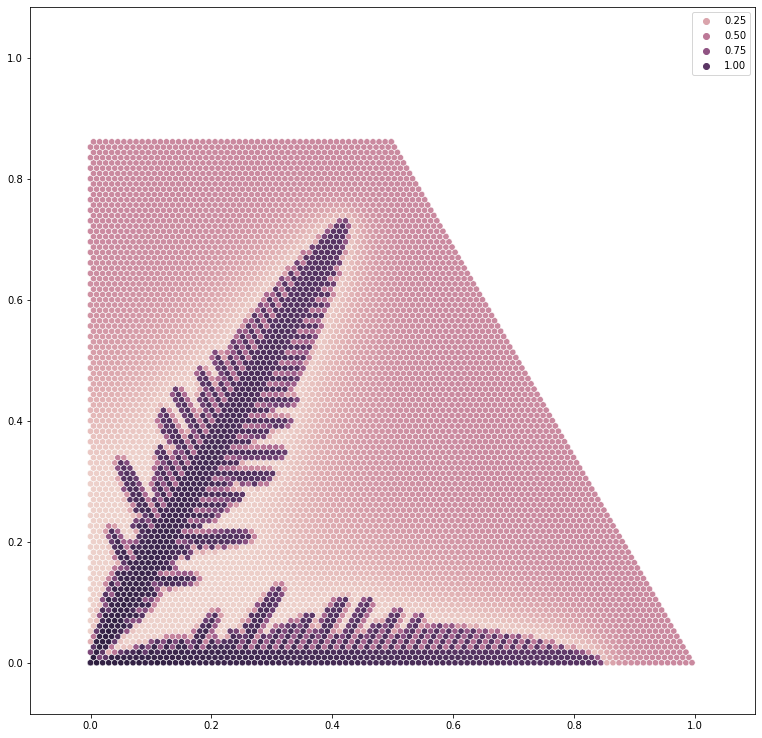

In [8]:
# control
tctr = 200
frame = 1

# simulation
for t in range(2000):
    
    # update Receptive region
    for c in cells:
        c.isIce = c.isI()
    for c in cells:
        c.isReceptive = c.isR()
    
    # time step
    for c in cells:
        c.u_new = c.diffuse() + c.grow(gamma)
    
    # assign
    for c in cells:
        c.u = c.u_new
    
    if t % tctr == 0:
        showAll(X, Y, cells)
#         plt.savefig('figs/%02d.png' % (frame))
#         with open('data/%02d.npy' % (frame), 'wb') as f:
#             np.save(f, X)
#             np.save(f, Y)
#             np.save(f, getU(cells))
        frame = frame + 1